# Full pipeline for analysis
to be run for the co-culture, tri-culture with glucose, and tri-culture with glucose / xylose

load model in reframed for analysis with SteadyCom / SteadierCom

In [1]:
from reframed import Community, Environment
from reframed import load_cbmodel, FBA, plot_flux_envelope

# load all models into reframed
CAL11 = load_cbmodel("GEMs/CAL11.xml", flavor="bigg")
SAL11 = load_cbmodel("GEMs/SAL11.xml", flavor="bigg")
MAM3 = load_cbmodel("GEMs/MAM3.xml", flavor="bigg")

# stop SAA module from looping by making the reactions one-way
SAL11.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
SAL11.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
SAL11.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
SAL11.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

In [2]:
# build community object
community = Community('RA_community', [CAL11, SAL11, MAM3])
merged_community = community.merge_models()

# get medium
medium = Environment.from_model(CAL11).apply(merged_community, exclusive=True, inplace=False)
# add xylose to the medium
medium["R_EX_xyl__D_e"] = (-8, float("inf"))

NOTE: glucose exchange lb is set to -10 and xylose to -8 to reflect the molar ratio of available glucose / xylose in the optimal media

## Experimental results

retrieve all datapoints to use for comparison, and print stats

In [3]:
import pandas as pd
import functions.data_analysis as data_analysis

# read data
relative_abundance_df = pd.read_csv("exp_data/subpop_data_xyl_glc.csv")
products_df = pd.read_csv("exp_data/conc_data_xyl_glc.csv")
od600_df = pd.read_csv("exp_data/od600_xyl_glc.csv")

subpop_df, conc_df, OD_df = data_analysis.process_data(relative_abundance_df, products_df, od600_df)

In [4]:
cal11_ra, sal11_ra, mam3_ra = data_analysis.get_relative_abundance_stats_triculture(subpop_df)

Relative SAl11 abundance at steady-state: 0.715428141
Relative CAL11 abundance at steady-state: 0.171697049
Relative MAM3 abundance at steady-state: 0.107159233


In [5]:
data_analysis.print_production_stats_triculture(conc_df)

Final RA concentration (mg/L): 171.8430034
Final RA amount (mmol): 0.047692463201622584
Final SAA concentration (mg/L): 34.81228669
Final SAA amount (mmol): 0.01756664096013225
Final CA concentration (mg/L): 59.55631399
Final CA amount (mmol): 0.03305793377901768


In [6]:
CA_yield, SAA_yield, RA_yield = data_analysis.get_yields_glc_xyl(conc_df)

CA yield 0.007273890784500001 g CA per g xylose
SAA yield 0.004310857623772064 g SAA per g glucose
RA yield 0.00859215017 g RA per g xylose


## Theoretical RA production
with SteadyCom / SteadierCom

In [16]:
from functions import updated_steadycom

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", sc_com_som.values["R_EX_rosma_e"])

RA production rate:  0.0011021704310743463


In [17]:
from reframed.community.simulation import simulate as SteadierCom

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", steadiercom_sim.values["R_EX_rosma_e"])

RA production rate:  4.126909975750305


- some note on the difference between steadycom and steadiercom

In [11]:
# # drafting - trying to diciper the fluxes in relation to each 

# rate_RA_MAM3 = steadiercom_sim.values["R_RAt_MAM3"]
# rate_SAA_SAL11 = steadiercom_sim.values["R_SAAt_SAL11"]
# rate_CA_CAL11 = steadiercom_sim.values["R_34DHCINMt_CAL11"]

# MAM3_max_lb = (rate_RA_MAM3 / steadiercom_sim.abundance["MAM3"])
# SAL11_max_lb = (rate_SAA_SAL11 / steadiercom_sim.abundance["SAL11"])
# CAL11_max_lb = (rate_CA_CAL11 / steadiercom_sim.abundance["CAL11"])

# # at the opt solution the lower bounds are then:
# print("MAM3 RA lb", MAM3_max_lb)
# print("SAL11 SAA lb", SAL11_max_lb)
# print("CAL11 CA lb", CAL11_max_lb)

### Relative species abundance

In [42]:
from reframed import SteadyComVA
from tqdm.notebook import tqdm

results_list = []

for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadyComVA(community, constraints=medium, obj_frac=frac)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df.set_index("frac");

  0%|          | 0/11 [00:00<?, ?it/s]

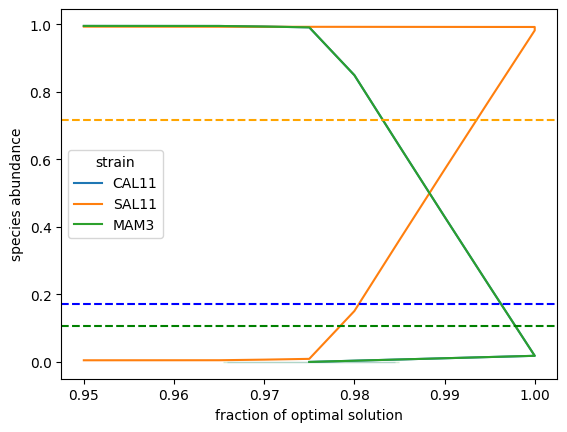

In [43]:
from functions.plot_results import plot_relative_abundance_glc_xyl

plot_relative_abundance_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra)

exact same analysis - but using the steadiercomFVA instead:

In [44]:
from functions.steadiercom import SteadierComFVA
from tqdm.notebook import tqdm

results_list = []

for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadierComFVA(community, constraints=medium, obj_frac=frac, allocation=True)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df.set_index("frac");

  0%|          | 0/11 [00:00<?, ?it/s]

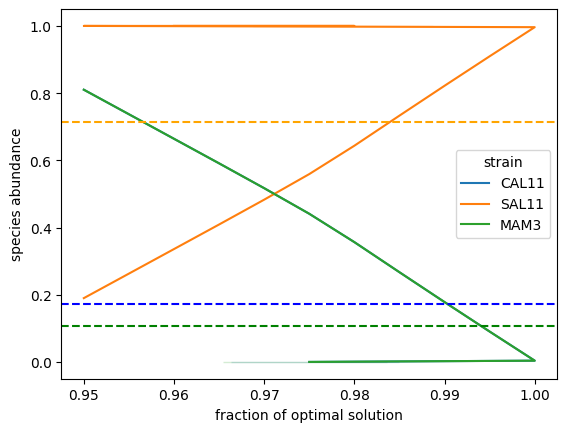

In [45]:
plot_relative_abundance_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra)

- with the enzyme allocation constraints we can see that the solution-space is more narrow, and we need to move further away from the fraction on optimum to be within the same ranges as the exp. values (98.5%)

In [9]:
from functions import updated_steadycom
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from reframed.community.simulation import simulate as SteadierCom

num_points = 11

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0, num=num_points)

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadyComVA(community, constraints=all_constraints, obj_frac=0.99)

    com_fva_solution["RA_prod_rate"] = RA_level
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df["RA_percentage"] = np.linspace(100, 0, num_points);

  0%|          | 0/11 [00:00<?, ?it/s]

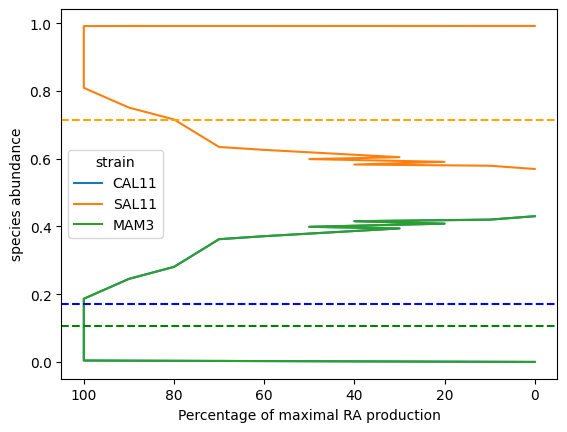

In [10]:
from functions.plot_results import plot_relative_abundance_RA_prod_glc_xyl

plot_relative_abundance_RA_prod_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra)

- we see the problems of steadycom clearly, we can have almost 0 cal11/MAM3 beucase their production fluxes are so high - I should implement steadiercom FVA version to use here!

In [11]:
from reframed.community.simulation import simulate as SteadierCom
from functions.steadiercom import SteadierComFVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

num_points = 11

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0, num=num_points)

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadierComFVA(community, constraints=all_constraints, obj_frac=0.9, allocation=True)

    com_fva_solution["RA_prod_rate"] = RA_level
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df["RA_percentage"] = np.linspace(100, 0, num_points);

  0%|          | 0/11 [00:00<?, ?it/s]

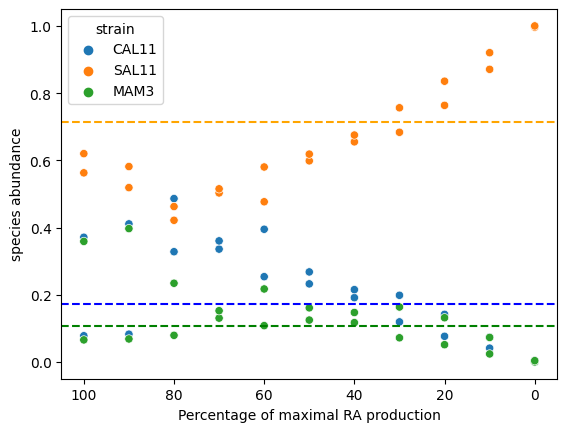

In [10]:
from functions.plot_results import plot_relative_abundance_RA_prod_glc_xyl

#this is for obj_frac = 1.0
plot_relative_abundance_RA_prod_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra, scatter=True)

- We can actually get the exact species distribution at aprox 30% of theoretical max RA production rate!
    - 4.126909975750305 * 0.3 = 1.23807299
    - so when the community produces RA at a rate of 1.23807299 we should get close to exp results.

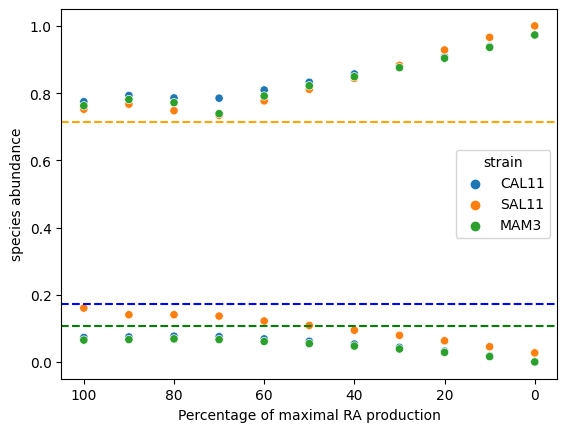

In [12]:
#this is for obj_frac = 0.9
plot_relative_abundance_RA_prod_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra, scatter=True)

- consistant with exp. data straight away

## Model preperation for dfba sim.

required calculations for the duynamic sim, write some equations on parameters ect.
add the yield calculations

In [16]:
### ----- Here: using the results from steadiercomFVA %RA plot to set lb's that correspond to the RA prodiuction level which seemed to be correct

# TODO: scale this lb number appropriatly using gDW and run dfba simulation using tese figures!!

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

lb_RA = max_RA*0.3

constraints_with_RA_lb = medium
constraints_with_RA_lb["R_EX_rosma_e"] = (lb_RA, float("inf"))
    
steadiercom_sim = SteadierCom(community, allocation=True, constraints=constraints_with_RA_lb)

MAM3_lb = (lb_RA / steadiercom_sim.abundance["MAM3"])
SAL11_lb = (lb_RA / steadiercom_sim.abundance["SAL11"])
CAL11_lb = (lb_RA / steadiercom_sim.abundance["CAL11"])

# at the opt solution the lower bounds are then:
print("MAM3 RA lb:", MAM3_lb)
print("SAL11 SAA lb:", SAL11_lb)
print("CAL11 CA lb:", CAL11_lb)

In [48]:
# ------ instead of lower bounds, calculate YIELDS!

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

lb_RA = max_RA*0.3

constraints_with_RA_lb = medium
constraints_with_RA_lb["R_EX_rosma_e"] = (lb_RA, float("inf"))
    
steadiercom_sim = SteadierCom(community, allocation=True, constraints=constraints_with_RA_lb)

RA_yield = steadiercom_sim.values["R_RAt_MAM3"] / steadiercom_sim.values["R_XYLtex_MAM3"]
SAA_yield = steadiercom_sim.values["R_SAAt_SAL11"] / steadiercom_sim.values["R_GLCtex_copy2_SAL11"]
CA_yield = steadiercom_sim.values["R_34DHCINMt_CAL11"] / steadiercom_sim.values["R_XYLtex_CAL11"]

In [7]:
from cobra.io import read_sbml_model
from functions.modify_GEM import add_ratio_constraint_cobra

# ----- read cobrapy models -----

CAL11_cobra = read_sbml_model("GEMs/CAL11.xml")
SAL11_cobra = read_sbml_model("GEMs/SAL11.xml")
MAM3_cobra = read_sbml_model("GEMs/MAM3.xml")

# ----- add yield ratio constraint -----

# knock out GLCtex_copy1 in SAL11, just so I have one less thing to worry about...
SAL11_cobra.reactions.get_by_id("GLCtex_copy1").bounds = (0.0, 0.0)

add_ratio_constraint_cobra(CAL11_cobra, "34DHCINMt", "XYLtex", CA_yield);
add_ratio_constraint_cobra(SAL11_cobra, "SAAt", "GLCtex_copy2", SAA_yield);
add_ratio_constraint_cobra(MAM3_cobra, "RAt", "XYLtex", RA_yield);

# this also worked pretty bad...:( yields were so high that there was no production

### parameters

A list of parameters that were set according to the experimental conditions, all other params are default:

- glucose
    - 3 g/L in 0.1 L gives (equation) = x mmol/L glucose
- xylose
    - 2 g/L in 0.1L gives (equation) = x mmol/L xylose
- volume in the box
- cycles
- out-flow-rate
    - = 0
- Km and Vmax
    - taken from paper (here list the paper)
- inocculum
    - use the exp measured data so that they start evenly maybe?

## Dynamic simulation

running simulation with COMETS

In [8]:
from functions.dfba_comets import simulate_xyl_glc_triculture

sim = simulate_xyl_glc_triculture(CAL11_cobra, SAL11_cobra, MAM3_cobra, initial_pop=2.e-3)


Running COMETS simulation ...
Done!


### Total biomass

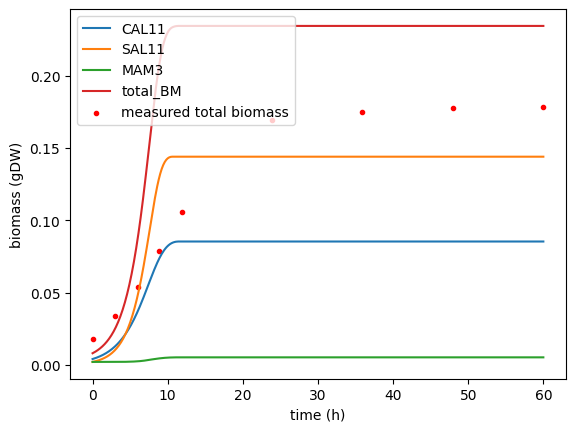

In [9]:
from functions.plot_results import plot_biomass_time_course

plot_biomass_time_course(sim.total_biomass, OD_df)

### Relative species abundance time-course

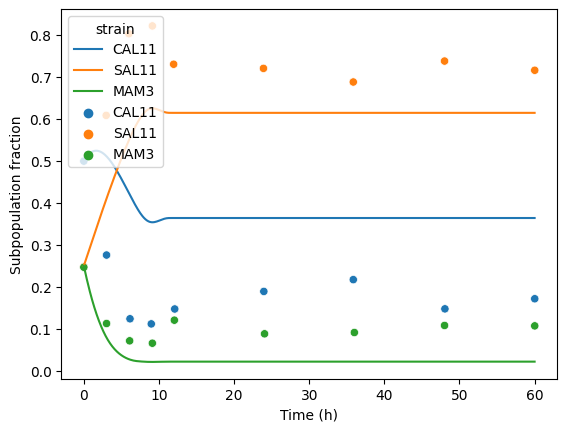

In [10]:
from functions.plot_results import plot_relative_abundance_time_course

plot_relative_abundance_time_course(sim.total_biomass, subpop_df)

### Production time-course

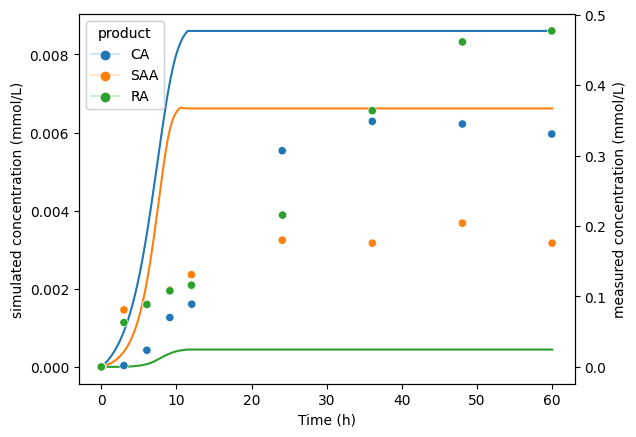

In [11]:
from functions.plot_results import plot_production_time_course

plot_production_time_course(sim.get_metabolite_time_series(), conc_df)

### Fluxes

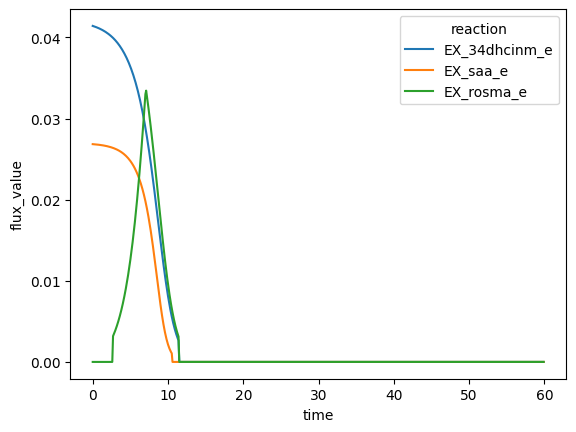

In [13]:
from functions.plot_results import plot_production_flux_values

plot_production_flux_values(sim)

### Metabolites

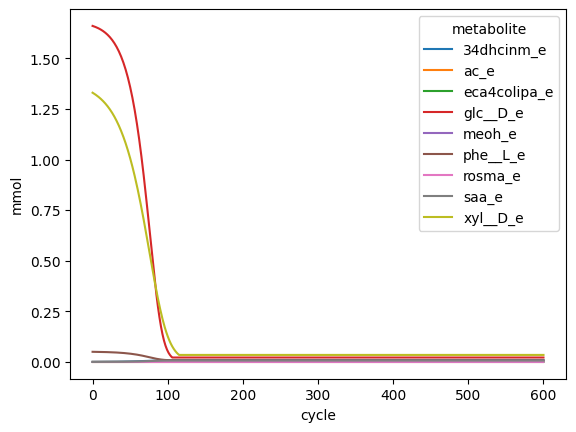

In [14]:
from functions.plot_results import plot_metabolites

plot_metabolites(sim)

### load results from the pairwise comparison (run from terminal)